In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import time

# Set random seeds for reproducibility
RANDOM_SEED = 50
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
class DiamondPriceMLP(nn.Module):
    """
    Multi-Layer Perceptron for Diamond Price Prediction
    
    Architecture:
    - Input layer (n_features)
    - Multiple hidden layers with ReLU, BatchNorm, and Dropout
    - Output layer (1 neuron for regression)
    """
    
    def __init__(self, input_dim, hidden_dims, dropout_rate=0.3, use_batch_norm=True):
        super(DiamondPriceMLP, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        layers = []
        
        # Input to first hidden layer
        prev_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            # Linear layer
            layers.append(nn.Linear(prev_dim, hidden_dim))
            
            # Batch normalization (optional)
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Activation
            layers.append(nn.ReLU())
            
            # Dropout
            layers.append(nn.Dropout(dropout_rate))
            
            prev_dim = hidden_dim
        
        # Output layer (no activation for regression)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()  # Remove extra dimension

In [3]:
# Get the current working directory (for Jupyter Notebooks)
script_dir = os.getcwd()

# Define the path to the preprocessed data directory relative to the script's location
data_dir = os.path.join(script_dir, 'data')

# Define the path to the models directory relative to the parent directory of the script's location
models_dir = os.path.join(os.path.dirname(script_dir), 'models')

# Create the models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

In [76]:
# Load the preprocessed data
X_train = np.load(f'{data_dir}/X_train_final.npy')
X_val = np.load(f'{data_dir}/X_val_final.npy')
X_test = np.load(f'{data_dir}/X_test_final.npy')

y_train_log = np.load(f'{data_dir}/y_train_log.npy')  # Log-transformed version!
y_val_log = np.load(f'{data_dir}/y_val_log.npy')
y_test_log = np.load(f'{data_dir}/y_test_log.npy')

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_log_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_val_log_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)
y_test_log_tensor = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

# Create Dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_log_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_log_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_log_tensor)

# Create DataLoader objects
batch_size = 32  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Overfitting a single batch

epoch: 0 loss: 64.64643859863281
epoch: 5 loss: 15.372428894042969
epoch: 10 loss: 5.548412799835205
epoch: 15 loss: 1.6594730615615845
epoch: 20 loss: 0.4836699962615967
epoch: 25 loss: 0.2759513258934021
epoch: 30 loss: 0.3920825123786926
epoch: 35 loss: 0.3384254574775696
epoch: 40 loss: 0.18850882351398468
epoch: 45 loss: 0.07952484488487244
epoch: 50 loss: 0.03767556697130203
epoch: 55 loss: 0.026389900594949722
epoch: 60 loss: 0.021400950849056244
epoch: 65 loss: 0.021860774606466293
epoch: 70 loss: 0.020138148218393326
epoch: 75 loss: 0.018486589193344116
epoch: 80 loss: 0.017138872295618057
epoch: 85 loss: 0.015692835673689842
epoch: 90 loss: 0.014607719145715237
epoch: 95 loss: 0.013839075341820717
epoch: 100 loss: 0.013005201704800129
epoch: 105 loss: 0.012316005304455757
epoch: 110 loss: 0.011673619039356709
epoch: 115 loss: 0.011040654964745045
epoch: 120 loss: 0.010401779785752296
epoch: 125 loss: 0.009766587987542152
epoch: 130 loss: 0.009162026457488537
epoch: 135 loss: 

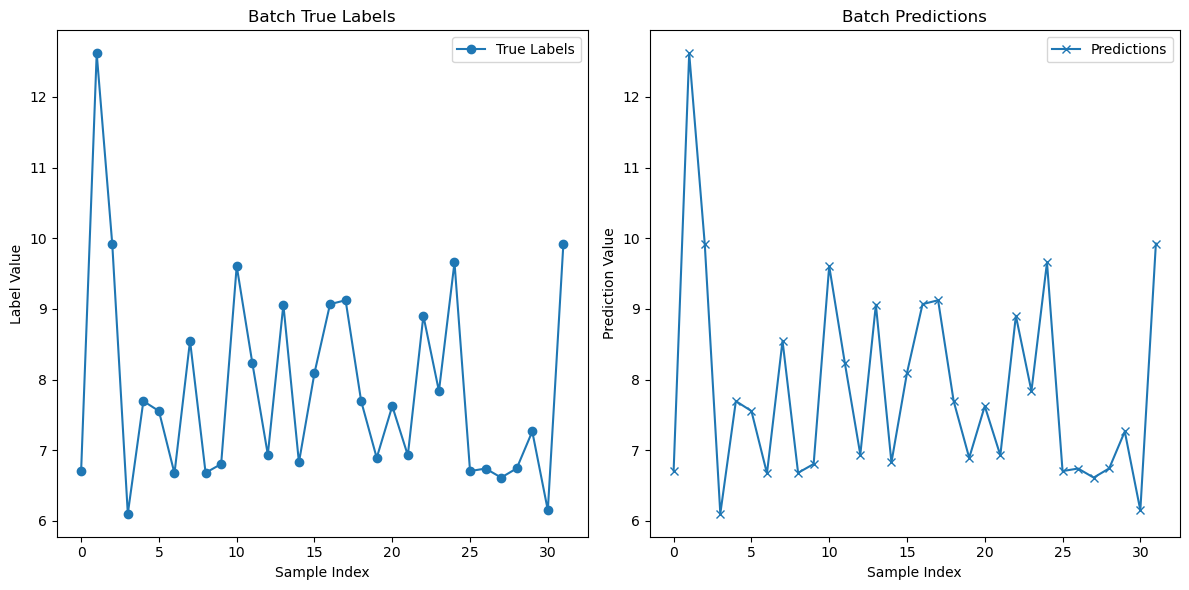

In [ ]:
# Overfit a single batch for debugging

# Create DataLoader objects
batch_size = 32  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get a single batch to overfit
single_batch = next(iter(train_loader))
features, targets = single_batch
features = features.to(device)
targets = targets.to(device)

# define hyper-parmeters and create our model
num_features = 55
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 2000
# loss criterion
criterion = nn.MSELoss()
# model
model = DiamondPriceMLP(num_features, [128, 64, 32, 16], 0, False).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop for the model
for epoch in range(num_epochs):
    model.train()  # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
    epoch_losses = []
    
    # send data to device
    features = features.to(device)
    targets = targets.to(device)
    
    # forward pass
    output = model(features)  # calls model.forward(features)
    # loss
    loss = criterion(output.view(-1), targets.view(-1))
    # backward pass
    optimizer.zero_grad()  # clean the gradients from previous iteration, clears the `tensor.grad` field (tensor.grad=0)
    loss.backward()  # autograd backward to calculate gradients, assigns the `tensor.grad` field (e.g., tensor.grad=0.27)
    optimizer.step()  # apply update to the weights, applies the gradient update rule of the optimizer (param=param - lr * grad)
    
    epoch_losses.append(loss.item())
    
    # Store batch data for visualization
    if epoch == num_epochs - 1:  # Only store in the first epoch
        batch_features = features.cpu().numpy()
        batch_targets = targets.cpu().numpy()
        batch_predictions = output.detach().cpu().numpy()
    """
    if epoch == 500 or epoch == 1000 or epoch == 1500:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1  # Reduce by 10x
            print(f"Learning rate reduced to: {param_group['lr']}")
    """
    if epoch % 5 == 0:
        print(f'epoch: {epoch} loss: {np.mean(epoch_losses)}')

# Visualization
plt.figure(figsize=(12, 6))

# Plot true labels
plt.subplot(1, 2, 1)
plt.plot(batch_targets, label='True Labels', marker='o')
plt.title('Batch True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.plot(batch_predictions, label='Predictions', marker='x')
plt.title('Batch Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Value')
plt.legend()

plt.tight_layout()
plt.show()

# A regular run

In [81]:
# Create DataLoader objects
batch_size = 128  # You can adjust the batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [84]:
# define hyper-parmeters and create our model
num_features = 55
output_dim = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 500
# loss criterion
criterion = nn.MSELoss()
# model
model = DiamondPriceMLP(num_features, [128, 64, 32], 0, False).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
# training loop for the model
for epoch in range(num_epochs):
    model.train()  # change the mode to training, activating layers like DropOut and BatchNorm, if there are any
    epoch_losses = []
    
    for features, targets in train_loader:
        # send data to device
        features = features.to(device)
        targets = targets.to(device)
        
        # forward pass
        output = model(features)  # calls model.forward(features)
        # loss
        loss = criterion(output.view(-1), targets.view(-1))
        # backward pass
        optimizer.zero_grad()  # clean the gradients from previous iteration, clears the `tensor.grad` field (tensor.grad=0)
        loss.backward()  # autograd backward to calculate gradients, assigns the `tensor.grad` field (e.g., tensor.grad=0.27)
        optimizer.step()  # apply update to the weights, applies the gradient update rule of the optimizer (param=param - lr * grad)
        
        epoch_losses.append(loss.item())
        
        """
        if epoch == 500 or epoch == 1000 or epoch == 1500:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.1  # Reduce by 10x
                print(f"Learning rate reduced to: {param_group['lr']}")
        """
    if epoch % 5 == 0:
        print(f'epoch: {epoch} loss: {np.mean(epoch_losses)}')

epoch: 0 loss: 0.3436700079024413
epoch: 5 loss: 0.054041910586853655
epoch: 10 loss: 0.05457903342337141
epoch: 15 loss: 0.04307182146948856
epoch: 20 loss: 0.0421650604987142
epoch: 25 loss: 0.04667852918270525
epoch: 30 loss: 0.04015321550568903
epoch: 35 loss: 0.03942559701671836
epoch: 40 loss: 0.03889949831739693
epoch: 45 loss: 0.03856944434279139
epoch: 50 loss: 0.038150927196444334
epoch: 55 loss: 0.038041162889782064
epoch: 60 loss: 0.037972664812129714
epoch: 65 loss: 0.03749685631455516
epoch: 70 loss: 0.03742829756264344
epoch: 75 loss: 0.03717804124466325
epoch: 80 loss: 0.03762858209900258
epoch: 85 loss: 0.03677927214346026
epoch: 90 loss: 0.03659849781574269
epoch: 95 loss: 0.037130730191476946
epoch: 100 loss: 0.03660427755207423
epoch: 105 loss: 0.03667985243041493
epoch: 110 loss: 0.0364853745309211
epoch: 115 loss: 0.036096262088476765
epoch: 120 loss: 0.03652045490913993
epoch: 125 loss: 0.03654229807301781
epoch: 130 loss: 0.03622577639590424
epoch: 135 loss: 0.0